### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [190]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city,array_to_latex
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import Aer, transpile, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
import matplotlib.pyplot as plt
from qiskit import BasicAer, execute
import scipy as sc
import pandas as pd
from qiskit.circuit.library.data_preparation.state_preparation import *
#9329 con 6 res
#seed 10 con resolution 5
#6476 cambiando eigenvalues a 0.55 e 0.45 ris=7
# 12 con 4x4 matrix e risoluzione 7
#500  4x4 cambiando autovalori.
#4524
#8908
#4747 res 8
#6752
np.random.seed(19)

example_matrix=np.random.rand(2,2)


example_matrix=np.dot(example_matrix,example_matrix.T)
#example_matrix=np.array([[1.5,0.5],[0.5,1.5]])
#example_matrix=np.array([[0,0,0,0],[0.,1.,0,0],[0.,0.,2,0],[0.,0,0,3]])
sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.89705523 0.04318619 0.04318619 0.0165724 ]


In [191]:
example_matrix,np.linalg.eig(example_matrix)

(array([[0.58901393, 0.12923746],
        [0.12923746, 0.08005873]]),
 (array([0.61995037, 0.04912229]),
  array([[ 0.9725247 , -0.23279972],
         [ 0.23279972,  0.9725247 ]])))

In [192]:
example_matrix1=example_matrix/np.trace(example_matrix)
example_matrix1,np.linalg.eig(example_matrix1)

(array([[0.88034375, 0.19315908],
        [0.19315908, 0.11965625]]),
 (array([0.92658152, 0.07341848]),
  array([[ 0.9725247 , -0.23279972],
         [ 0.23279972,  0.9725247 ]])))

In [203]:
eig,e_v=np.linalg.eig(example_matrix)
#b=np.array([3,1])
#b=np.array([.6,.3,.07,0.03])
b=np.array([9.37,4.42])
#b=np.array([.7,.2,.06,0.04])
BB = e_v@np.diag(b)@e_v.T
BB, np.linalg.eig(BB)
example_matrix2=BB

sum_squares = (example_matrix2**2).sum()
input_probabilities = (example_matrix2**2/sum_squares).flatten()
example_matrix2=example_matrix2/np.trace(example_matrix2)
print(input_probabilities)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 4)

In [204]:
example_matrix2,np.linalg.eig(example_matrix2)

NameError: name 'example_matrix2' is not defined

In [205]:
np.trace(example_matrix)*np.linalg.eig(example_matrix1)[0]

array([5.26302034, 0.02004453, 0.55041217, 0.32499418])

In [193]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    for k in range(1, int(np.ceil(np.log2(len(example_matrix)**2)))+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.ceil(np.log2(len(example_matrix)**2))))))][:len(input_probabilities)]
    
    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    
    #add root tree
    nodes.insert(0, 1)
    thetas=[]

    idx=0
    for i in range(1,len(nodes),2):
        
        right_node=i
        left_node=right_node+1
        if nodes[idx]!=0:
            thetas.append(2*np.arccos(nodes[right_node]/nodes[idx]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[idx]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [194]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    #qc=QuantumCircuit(len(example_matrix))
    qc=QuantumCircuit(int(np.ceil(np.log2(len(example_matrix)**2))))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

0 -> 0.9696604633240288
1 -> 0.24445569305342432
00 -> 0.9471299950763292
01 -> 0.20781286428054138
10 -> 0.20781286428054138
11 -> 0.1287338312400718


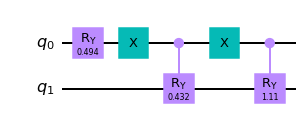

In [212]:
thetas, all_combinations = thetas_computation(example_matrix1)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw('mpl')

In [196]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


{'00': 0.897055227573288,
 '01': 0.043186186560483,
 '10': 0.043186186560483,
 '11': 0.016572399305747}

In [198]:
#Unitary for PE
resolution = 4
unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_3490/1240717140.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)


Operator([[ 8.95473769e-01-0.39686772j, -2.46828593e-17-0.20155084j],
          [-2.46828593e-17-0.20155084j,  8.95473769e-01+0.39686772j]],
         input_dims=(2,), output_dims=(2,))

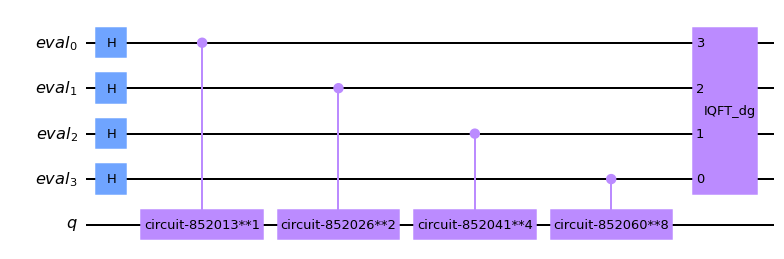

In [199]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

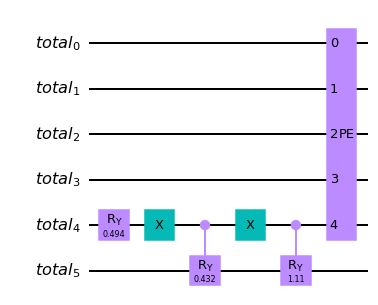

In [200]:
tot_qubit = resolution+len(example_matrix1)

qr_total_sim = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit_sim = QuantumCircuit(qr_total_sim , name='matrix')

total_circuit_sim.append(matrix_circuit.to_gate(), qr_total_sim[resolution:])
total_circuit_sim.append(pe.to_gate(), qr_total_sim[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit_sim.decompose(reps=1).draw("mpl")

In [201]:
# Create the first operator for tomography
op_U=total_circuit_sim.to_gate(label='op_U').control()

In [202]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit_sim, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [203]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [204]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
sim_statevector=attach_bitstrings(statevector)


In [205]:
int(np.log2(len(sim_statevector))-4)

2

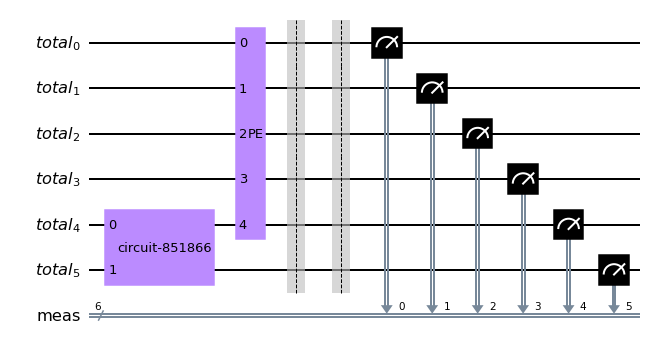

In [206]:
tot_qubit = resolution+len(example_matrix1)
#print(tot_qubit)
qr_total = QuantumRegister(tot_qubit, 'total')

total_circuit = QuantumCircuit(qr_total, name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
total_circuit.barrier()
total_circuit.measure_all()
total_circuit.draw("mpl")

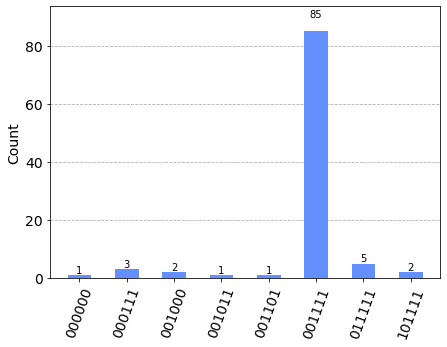

In [207]:
n_shots=100
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

In [208]:
for i in counts:
    counts[i]/=n_shots
#counts

In [209]:
statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
#statevector

In [210]:
#Create second operator tomography
op_V = StatePreparation(np.sqrt(statevector),label='c_V').control()

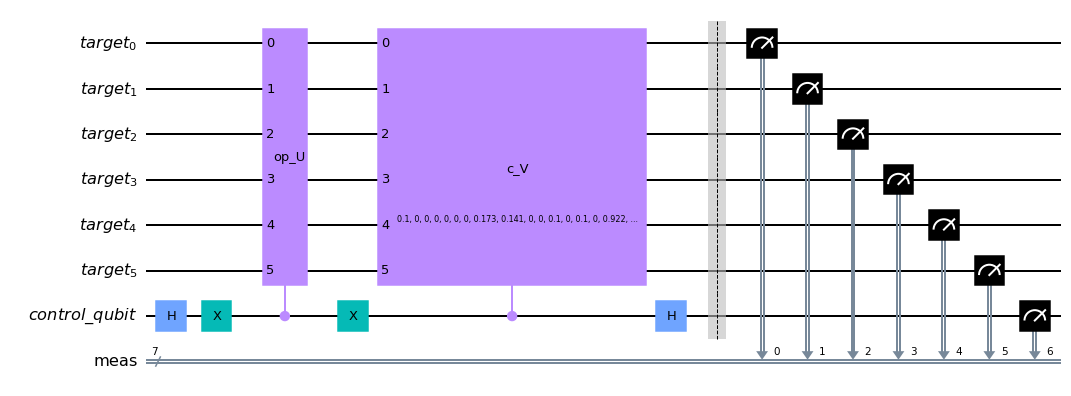

In [211]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'target')
qr_control = QuantumRegister(1, 'control_qubit')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_control, name='matrix')
total_circuit_2.h(qr_control)
total_circuit_2.x(qr_control)

total_circuit_2.append(op_U, qr_control[:]+qr_total_xi[:])
total_circuit_2.x(qr_control)
total_circuit_2.append(op_V, qr_control[:]+qr_total_xi[:])
total_circuit_2.h(qr_control)
total_circuit_2.measure_all()
total_circuit_2.draw("mpl")

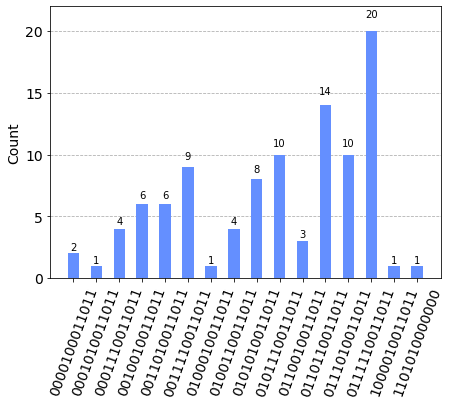

In [90]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [91]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**tot_qubit)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
#tmp

In [92]:
###Metodo Nannicini

'''tmp_=tmp/(sum(tmp))

sign_diff=[]
sign=[]
x_list=[]
for i in range(len(tmp_)):
    x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))
    
    x_list.append(x)
    
    sign_diff.append(np.sign(x)+np.sign((sim_statevector[i][1].real)))
    sign.append(np.sign(x))
    '''

'tmp_=tmp/(sum(tmp))\n\nsign_diff=[]\nsign=[]\nx_list=[]\nfor i in range(len(tmp_)):\n    x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))\n    \n    x_list.append(x)\n    \n    sign_diff.append(np.sign(x)+np.sign((sim_statevector[i][1].real)))\n    sign.append(np.sign(x))\n    '

In [93]:
#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=1
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

In [94]:
statevector_dictionary={}
for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

#statevector_dictionary

In [95]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
#ss

In [96]:
df=pd.DataFrame(ss)

df.columns=['state','module']
df

,state,module
0,000000000000,0.0
1,000000000001,0.0
2,000000000010,0.0
3,000000000011,0.0
4,000000000100,0.0
...,...,...
4091,111111111011,0.0
4092,111111111100,0.0
4093,111111111101,0.0
4094,111111111110,0.0


In [97]:
df['lambda']=df['state'].apply(lambda x: x[-resolution:])
df1=df.groupby('lambda').agg({'module':'sum'})
#df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df1=df1.sort_values('module',ascending=False)
df1

,module
lambda,
10011011,0.96
00011011,0.01
01000000,0.01
01011011,0.01
00011000,0.01
...,...
01011100,0.00
01011101,0.00
01011110,0.00


In [98]:
tail=df1.reset_index()
tail

,lambda,module
0,10011011,0.96
1,00011011,0.01
2,01000000,0.01
3,01011011,0.01
4,00011000,0.01
...,...,...
251,01011100,0.00
252,01011101,0.00
253,01011110,0.00
254,01011111,0.00


In [99]:
tail['num']=tail['lambda'].apply(lambda x :int(x[::-1],base=2)/(2**resolution))

In [100]:
tail.head(20)

,lambda,module,num
0,10011011,0.96,0.847656
1,00011011,0.01,0.843750
2,01000000,0.01,0.007812
3,01011011,0.01,0.851562
4,00011000,0.01,0.093750
5,10101001,0.00,0.582031
6,10101101,0.00,0.707031
7,10101100,0.00,0.207031
8,10101011,0.00,0.832031
9,10101010,0.00,0.332031


In [101]:
'''tail1['num']+=0.1
tail1'''

"tail1['num']+=0.1\ntail1"

In [102]:
np.linalg.eig(example_matrix1)

(array([0.84780975, 0.09557902, 0.05370488, 0.00290634]),
 array([[-0.27669967, -0.30381059,  0.88229208,  0.2295585 ],
        [-0.48274483,  0.77216236,  0.20746302, -0.35732594],
        [-0.47083591,  0.16297368, -0.30291613,  0.81240073],
        [-0.68462272, -0.53376399, -0.29455322, -0.39953239]]))

In [160]:
from scipy.signal import find_peaks

peaks=[]
nums_peaks=[]
offset=1/n_shots
stop=False
while stop==False:
    right_thresholds=find_peaks(tail.sort_values(['num'])['module'],threshold=offset)[1]['right_thresholds']
    left_thresholds=find_peaks(tail.sort_values(['num'])['module'],threshold=offset)[1]['left_thresholds']
    mean=(right_thresholds+left_thresholds)/2
    p=find_peaks(tail.sort_values(['num'])['module'],threshold=offset)[0]
    if len(p)>len(example_matrix1):
        offset+=1/n_shots
    else:
        stop=True
        for i in p:
            el = tail.sort_values(['num']).iloc[i]
            nums_peaks.append(el['num'])
            peaks.append(el['lambda'])

sorted_peaks=np.array(peaks)[mean.argsort()[::-1]]
sorted_num_peaks=np.array(nums_peaks)[mean.argsort()[::-1]]
peaks,np.array(nums_peaks)

(['01000000', '00011000', '10011011'],
 array([0.0078125 , 0.09375   , 0.84765625]))

In [153]:
sorted_num_peaks

array([0.84765625, 0.09375   , 0.0078125 ])

In [162]:
np.array(nums_peaks)[np.argwhere(mean != np.amin(mean))]

array([[0.84765625]])

In [158]:
min_=10000
values_not_to_keep=[]
for k in np.array(nums_peaks)[~np.argwhere(mean == np.amin(mean))]:
    a=find_nearest(np.linalg.eig(example_matrix1)[0],k[0])
    gg=abs(a-k[0])
    if gg<min_:
        min_=gg
        value_to_keep=k[0]
    

print(value_to_keep)


0.84765625


In [148]:
idx=[list(sorted_num_peaks).index(x) for x in values_not_to_keep if x in sorted_num_peaks]
idx

[2]

In [157]:
values_not_to_keep=[v for v in np.array(nums_peaks)[np.argwhere(mean == np.amin(mean))] if v!=value_to_keep]
values_not_to_keep

[array([0.84765625])]

In [143]:
new_peaks=[v for v in sorted_num_peaks if v not in values_not_to_keep]
new_peaks

[0.84765625, 0.09375]

In [104]:
right_thresholds,left_thresholds

(array([0.01, 0.01, 0.95]), array([0.01, 0.01, 0.95]))

In [64]:
(right_thresholds+left_thresholds)/2

array([0.004, 0.002, 0.98 ])

In [41]:
sorted_peaks,sorted_num_peaks,right_thresholds

(array(['10011011', '10000000', '01110000'], dtype='<U8'),
 array([0.84765625, 0.00390625, 0.0546875 ]),
 array([0.009, 0.005, 0.977]))

In [303]:
check_eigenvalues={}
for i in np.linalg.eig(example_matrix1)[0]:
    check_eigenvalues.update({i:0})
check_eigenvalues

{0.8955238958986377: 0,
 0.00030420453127693393: 0,
 0.05567682172622658: 0,
 0.04849507784385881: 0}

In [125]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [305]:
for s_p in sorted_num_peaks:
    x=find_nearest(np.linalg.eig(example_matrix1)[0],s_p)
    print(x)
    if check_eigenvalues[x]==0:
        check_eigenvalues.update({x:1})
    else:
        continue
print(check_eigenvalues)

0.8955238958986377
0.05567682172622658
0.04849507784385881
{0.8955238958986377: 1, 0.00030420453127693393: 0, 0.05567682172622658: 1, 0.04849507784385881: 1}


In [306]:
new_original_eigenvalues=[]
for d in list(check_eigenvalues.keys()):
    if check_eigenvalues[d]==1:
        check_eigenvalues.pop(d)
        new_original_eigenvalues.append(d)
        #new_original_eigenvalues.append(d)
        #del check_eigenvalues[d]
check_eigenvalues

{0.00030420453127693393: 0}

In [307]:
if len(check_eigenvalues)>0:
    new_original_eigenvalues.append(list(check_eigenvalues.keys())[0])
else:
    new_original_eigenvalues=sorted(new_original_eigenvalues,reverse=True)
new_original_eigenvalues

[0.8955238958986377,
 0.05567682172622658,
 0.04849507784385881,
 0.00030420453127693393]

In [317]:
np.linalg.eig(example_matrix1),np.linalg.eig(example_matrix1)[1][:,1]

((array([8.95523896e-01, 3.04204531e-04, 5.56768217e-02, 4.84950778e-02]),
  array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
         [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
         [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
         [-0.54730826,  0.17339042,  0.45175377,  0.68286746]])),
 array([-0.31079311, -0.72369209,  0.59128095,  0.17339042]))

In [334]:
new_idx=[]
for i in new_original_eigenvalues:
    for j in range(len(np.linalg.eig(example_matrix1)[0])):
        if i==np.linalg.eig(example_matrix1)[0][j]:
            new_idx.append(np.linalg.eig(example_matrix1)[1][:,j])
            
new_idx=np.array(new_idx)

In [336]:
new_idx.reshape(4,4).T

array([[-0.54010974, -0.76691778,  0.15338266, -0.31079311],
       [-0.34101425,  0.45528741, -0.39075876, -0.72369209],
       [-0.54078131,  0.021657  , -0.59789078,  0.59128095],
       [-0.54730826,  0.45175377,  0.68286746,  0.17339042]])

In [306]:
peaks=[]
nums_peaks=[]
peaks.append(tail.iloc[0]['lambda'])
nums_peaks.append(tail.iloc[0]['num'])
for i in range(1,len(tail)):
    
    #for n_ in nums_peaks:
        
    if any(abs(tail.iloc[i]['num']-n_)<= 4/(2**resolution) for n_ in nums_peaks):
        #if any(abs(tail1.iloc[i]['num']-n_)/n_<= 0.2 for n_ in nums_peaks):
        pass
    else:
           
        nums_peaks.append(tail.iloc[i]['num'])
        peaks.append(tail.iloc[i]['lambda'])
        pass
    if len(peaks)==len(example_matrix1):
        break
    #print(tail.iloc[i])

In [307]:
peaks,np.array(nums_peaks)

(['010011011', '100011000', '010000000', '001110000'],
 array([0.84765625, 0.09570312, 0.00390625, 0.0546875 ]))

In [478]:
np.linalg.eig(example_matrix1)

(array([8.95523896e-01, 3.04204531e-04, 5.56768217e-02, 4.84950778e-02]),
 array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
        [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
        [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
        [-0.54730826,  0.17339042,  0.45175377,  0.68286746]]))

<AxesSubplot: xlabel='num'>

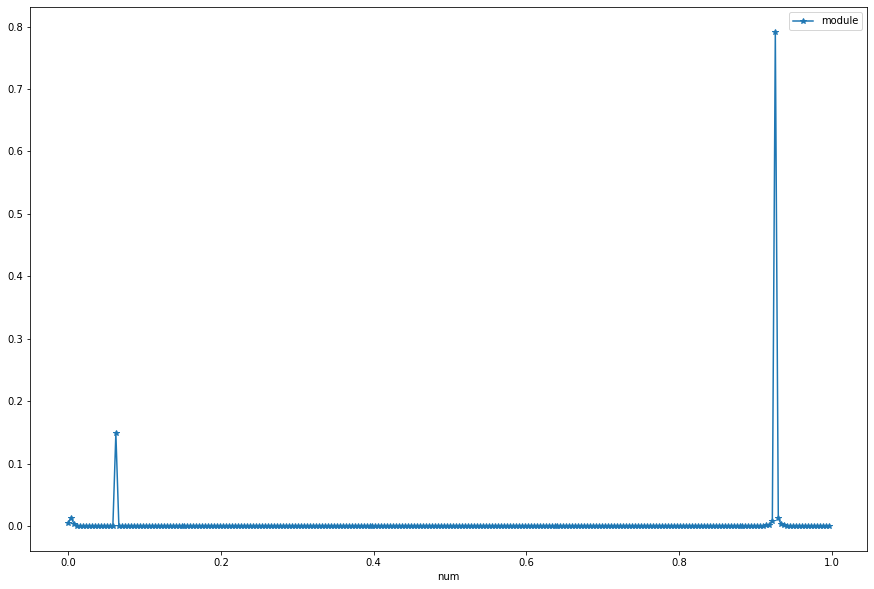

In [56]:
tail[['num','module']].sort_values('num').set_index('num').plot(style='-*',figsize=(15,10))

In [149]:
'''lambdas=df1.tail(len(example_matrix1)).index.values
lambdas'''

'lambdas=df1.tail(len(example_matrix1)).index.values\nlambdas'

In [58]:
lambdas=peaks
lambdas

['10000000', '00001000', '10101011', '10110111']

In [59]:
df.columns=['state','module','lambda']
df

,state,module,lambda
0,000000000000,0.000233,00000000
1,000000000001,0.000000,00000001
2,000000000010,0.000000,00000010
3,000000000011,0.000000,00000011
4,000000000100,0.000000,00000100
...,...,...,...
4091,111111111011,0.000013,11111011
4092,111111111100,0.000001,11111100
4093,111111111101,0.000003,11111101
4094,111111111110,0.000002,11111110


In [60]:
df['sign']=np.array(list(sign_dictionary.values()))
#df['sign']=np.array(sign)
df

,state,module,lambda,sign
0,000000000000,0.000233,00000000,1
1,000000000001,0.000000,00000001,1
2,000000000010,0.000000,00000010,1
3,000000000011,0.000000,00000011,1
4,000000000100,0.000000,00000100,1
...,...,...,...,...
4091,111111111011,0.000013,11111011,1
4092,111111111100,0.000001,11111100,-1
4093,111111111101,0.000003,11111101,-1
4094,111111111110,0.000002,11111110,1


In [61]:
df['module']=df['module'].multiply(np.array(list(sign_dictionary.values())), axis=0)
#df['module']=df['module'].multiply(np.array(sign), axis=0)
df=df.fillna(0)
df

,state,module,lambda,sign
0,000000000000,0.000233,00000000,1
1,000000000001,0.000000,00000001,1
2,000000000010,0.000000,00000010,1
3,000000000011,0.000000,00000011,1
4,000000000100,0.000000,00000100,1
...,...,...,...,...
4091,111111111011,0.000013,11111011,1
4092,111111111100,-0.000001,11111100,-1
4093,111111111101,-0.000003,11111101,-1
4094,111111111110,0.000002,11111110,1


In [62]:
#df['st']=sim_statevector

In [155]:
df.query("state.str.endswith('01111000')")

,state,module,lambda,sign


In [63]:
a=[]
save_sign=[]
eigenvalues=[]
for l in lambdas:
    eigenvalues.append(int(l[::-1],base=2)/(2**resolution))
    a_=np.array(df.query("state.str.endswith(@l)")['module'].values)
    #print(a_)
    save_sign.append(np.sign(a_))
    #print(save_sign)
    
    a.append(np.sqrt(abs(a_)))

#a=[a1,a2]

for i in range(len(a)):
    print(a[i])
    normalization_factor=np.sqrt((1/(sum(a[i]**2))))
    print(normalization_factor)
    a[i]*=normalization_factor
    a[i]*=save_sign[i]
    
    print(a)

[0.02507987 0.02236068 0.0043589  0.02349468 0.05309426 0.0490102
 0.00774597 0.04992995 0.00748331 0.00824621 0.00141421 0.00728011
 0.0372827  0.03532704 0.00663325 0.03576311]
8.570519095208521
[array([ 0.21494753,  0.19164263,  0.03735803, -0.20136161,  0.45504533,
        0.42004288, -0.06638696, -0.4279256 ,  0.06413589,  0.07067431,
       -0.01212054,  0.06239432,  0.31953212,  0.3027711 , -0.05685039,
       -0.30650841]), array([0.02893095, 0.08206095, 0.06979255, 0.03744329, 0.06483055,
       0.18222239, 0.15619859, 0.0828553 , 0.02238303, 0.06187083,
       0.05384236, 0.02819574, 0.05988322, 0.16736188, 0.14336318,
       0.07638063]), array([0.        , 0.00141421, 0.        , 0.00141421, 0.001     ,
       0.00173205, 0.001     , 0.00173205, 0.        , 0.        ,
       0.00141421, 0.00141421, 0.        , 0.00141421, 0.00173205,
       0.002     ]), array([0.07063993, 0.07819847, 0.15184861, 0.1659066 , 0.15098675,
       0.16642416, 0.325     , 0.35290367, 0.08472898

In [64]:
eigenvalues

[0.00390625, 0.0625, 0.83203125, 0.92578125]

In [65]:
#TODO: Capire se fare la media tra i vari fattori di rescaling
eigenvectors=[]
for ll, eig in zip(a,eigenvalues):
    
    eigenvector=np.zeros(len(example_matrix1)) #put length of eigenvector
    save_sign=np.sign(ll)
    sv=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(sv),len(example_matrix1))):
        max_list.append(max(sv[i:i+len(example_matrix1)]))
        scaled_statevectors.append(sv[i:i+len(example_matrix1)]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    #eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[len(example_matrix1)*idx_max:len(example_matrix1)*idx_max+len(example_matrix1)]
    eigenvectors.append((eig,eigenvector))
    print('reconstructed_eigenvector:',eigenvector)
    print('reconstructed_eigenvalue:', eig)
    

reconstructed_eigenvector: [ 0.67457048  0.62268198 -0.09841367 -0.63436751]
reconstructed_eigenvalue: 0.00390625
reconstructed_eigenvector: [-0.24464247  0.68762856 -0.58942598  0.31266008]
reconstructed_eigenvalue: 0.0625
reconstructed_eigenvector: [0.         0.4472136  0.54772256 0.63245553]
reconstructed_eigenvalue: 0.83203125
reconstructed_eigenvector: [0.28758094 0.31615219 0.61844804 0.6707187 ]
reconstructed_eigenvalue: 0.92578125


In [66]:
np.array(eigenvalues)*np.trace(example_matrix)

array([0.02165214, 0.34643423, 4.61190564, 5.13155698])

In [68]:
np.linalg.eig(example_matrix1)#,np.linalg.eig(example_matrix2)

(array([0.92621715, 0.0627798 , 0.00855031, 0.00245275]),
 array([[ 0.2853969 ,  0.24667974, -0.69415645, -0.61306161],
        [ 0.3130367 , -0.69532548,  0.35769244, -0.53906087],
        [ 0.61352923,  0.59211754,  0.5186184 , -0.06335345],
        [ 0.66643718, -0.32414257, -0.34819232,  0.57406897]]))